In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklift.models import (
    ClassTransformation,
    TwoModels,
   
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklift.metrics import uplift_at_k, qini_auc_score,uplift_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklift.metrics import qini_curve
from sklift.metrics import uplift_curve


In [2]:
enriched_final_rfm_df=pd.read_parquet('../csv_export/RFM.parquet')

In [3]:
enriched_final_rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223393 entries, 0 to 223392
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   CUSTOMER_ID                     223393 non-null  object 
 1   Recency                         223393 non-null  int64  
 2   Frequency                       223393 non-null  int64  
 3   Monetary                        223393 non-null  float64
 4   Total_Units                     223393 non-null  int64  
 5   Total_Organic_Discount          223393 non-null  float64
 6   Total_Extra_Discount            223393 non-null  float64
 7   Total_Discounts                 223393 non-null  float64
 8   AVG_ORGANIC_DISCOUNT_PER_ORDER  223393 non-null  float64
 9   USED_ORGANIC_DISCOUNT_RATIO     223393 non-null  float64
 10  AVG_EXTRA_DISCOUNT_PER_ORDER    223393 non-null  float64
 11  USED_EXTRA_DISCOUNT_RATIO       223393 non-null  float64
 12  AVG_TOTAL_DISCOU

In [4]:
enriched_final_rfm_df.dropna(inplace=True)

## Churn Label

In [5]:


categorical_cols = [
    'FAVOURITE_STORE',
    'FAVOURITE_STORE_TYPE',
    'FAVOURITE_PAYMENT_METHOD',
    'FAVORITE_CATEGORY',
    'FAVORITE_SUB_CATEGORY',
    'FAVORITE_WEEKDAY'
]

numerical_cols = [
    col for col in enriched_final_rfm_df.select_dtypes(include=['int64', 'float64']).columns
    if col != 'CUSTOMER_ID' and col != 'FAVORITE_HOUR'  
]

categorical_cols.append('FAVORITE_HOUR')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

X_processed = preprocessor.fit_transform(enriched_final_rfm_df)

num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = list(num_features) + list(cat_features)

X_df = pd.DataFrame(X_processed, columns=all_features, index=enriched_final_rfm_df.index)


## IsolationForest

In [6]:


iso_forest = IsolationForest(contamination=0.05, random_state=42)  
enriched_final_rfm_df['Anomaly_Score'] = iso_forest.fit_predict(X_df)

enriched_final_rfm_df['Churn_Label_IsoForest'] = (enriched_final_rfm_df['Anomaly_Score'] == -1).astype(int)


## LocalOutlierFactor


In [7]:


lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
enriched_final_rfm_df['LOF_Score'] = lof.fit_predict(X_df)

enriched_final_rfm_df['Churn_Label_LOF'] = (enriched_final_rfm_df['LOF_Score'] == -1).astype(int)


## OneClassSVM

In [8]:


oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')  
oc_svm.fit(X_df)

labels_ocsvm = oc_svm.predict(X_df)  
enriched_final_rfm_df['Churn_Label_OCSVM'] = (labels_ocsvm == -1).astype(int)


## Treatment


In [9]:
enriched_final_rfm_df['Treatment'] = (enriched_final_rfm_df['USED_EXTRA_DISCOUNT_RATIO'] > 0.05).astype(bool)


## Modelling 

In [10]:

models = {
    "TwoModels_XGB_vs_RF": TwoModels(
        estimator_trmnt=XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=6, eval_metric='logloss', random_state=42),
        estimator_ctrl=RandomForestClassifier(n_estimators=1000, random_state=42),
        method='vanilla'
    ),
      'tm_logreg_svm': TwoModels(
        estimator_trmnt=LogisticRegression(max_iter=1000),
        estimator_ctrl=SVC(probability=True),
        method='vanilla'
    ),
      'ct_xgb': ClassTransformation(
        estimator=XGBClassifier( eval_metric='logloss')
    ),
    'ct_rf': ClassTransformation(
        estimator=RandomForestClassifier(n_estimators=1000, random_state=42),
    ),

    
}


## Evaluation 

## IsoForest

In [11]:
yLabel_IsoForest = enriched_final_rfm_df.loc[X_df.index, 'Churn_Label_IsoForest']
treatment = enriched_final_rfm_df.loc[X_df.index, 'Treatment'].astype(int)



X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X_df, yLabel_IsoForest, treatment, test_size=0.3, stratify=treatment, random_state=42
)


In [29]:

results = {}
best_score = -1
best_model = None

for name, model in models.items():
    print(f"\n {name}...")

    model.fit(X_train, y_train, treat_train)
    preds = model.predict(X_test)
    
    qini_score = qini_auc_score(y_test, preds, treat_test)
    auuc_score = uplift_auc_score(y_test, preds, treat_test)
    upliftk=uplift_at_k(y_test, preds, treat_test,'by_group',k=0.1)
    results[name] = {
        "uplift": preds,
        "qini_auc": qini_score,
         "auuc": auuc_score,
         "Uplift@top10%": upliftk
    }
    print(f"\n Qini AUC: {qini_score:.4f} \n AUUC: {auuc_score:.4f} \n Uplift@top10%:{auuc_score:.4f} ")

    if qini_score > best_score:
        best_score = qini_score
        best_model = model



 TwoModels_XGB_vs_RF...

 Qini AUC: 0.4405 
 AUUC: 0.2299 
 Uplift@top10%:0.2299 

 tm_logreg_svm...

 Qini AUC: -0.2838 
 AUUC: -0.0462 
 Uplift@top10%:-0.0462 

 ct_xgb...

 Qini AUC: 0.2001 
 AUUC: 0.3465 
 Uplift@top10%:0.3465 

 ct_rf...

 Qini AUC: 0.2410 
 AUUC: 0.5332 
 Uplift@top10%:0.5332 


## OCSVM

In [30]:
yLabel_OCSVM = enriched_final_rfm_df.loc[X_df.index, 'Churn_Label_OCSVM']
treatment = enriched_final_rfm_df.loc[X_df.index, 'Treatment'].astype(int)


X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X_df, yLabel_OCSVM, treatment, test_size=0.3, stratify=treatment, random_state=42
)

In [31]:
for name, model in models.items():
    print(f"\n {name}...")

    model.fit(X_train, y_train, treat_train)
    preds = model.predict(X_test)
    
    qini_score = qini_auc_score(y_test, preds, treat_test)
    auuc_score = uplift_auc_score(y_test, preds, treat_test)
    upliftk=uplift_at_k(y_test, preds, treat_test,'by_group',k=0.1)
    results[name] = {
        "uplift": preds,
        "qini_auc": qini_score,
         "auuc": auuc_score,
         "Uplift@top10%": upliftk
    }
    print(f"\n Qini AUC: {qini_score:.4f} \n AUUC: {auuc_score:.4f} \n Uplift@top10%:{auuc_score:.4f} ")

    if qini_score > best_score:
        best_score = qini_score
        best_model = model


 TwoModels_XGB_vs_RF...

 Qini AUC: 0.6018 
 AUUC: 0.4273 
 Uplift@top10%:0.4273 

 tm_logreg_svm...

 Qini AUC: 0.1760 
 AUUC: 0.0565 
 Uplift@top10%:0.0565 

 ct_xgb...

 Qini AUC: 0.4571 
 AUUC: 0.5309 
 Uplift@top10%:0.5309 

 ct_rf...

 Qini AUC: 0.3520 
 AUUC: 0.5330 
 Uplift@top10%:0.5330 


## LOF

In [32]:
yLabel_LOF = enriched_final_rfm_df.loc[X_df.index, 'Churn_Label_LOF']
treatment = enriched_final_rfm_df.loc[X_df.index, 'Treatment'].astype(int)



X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X_df, yLabel_LOF, treatment, test_size=0.3, stratify=treatment, random_state=42
)



In [33]:
for name, model in models.items():
    print(f"\n {name}...")

    model.fit(X_train, y_train, treat_train)
    preds = model.predict(X_test)
    
    qini_score = qini_auc_score(y_test, preds, treat_test)
    auuc_score = uplift_auc_score(y_test, preds, treat_test)
    upliftk=uplift_at_k(y_test, preds, treat_test,'by_group',k=0.1)
    results[name] = {
        "uplift": preds,
        "qini_auc": qini_score,
         "auuc": auuc_score,
         "Uplift@top10%": upliftk
    }
    print(f"\n Qini AUC: {qini_score:.4f} \n AUUC: {auuc_score:.4f} \n Uplift@top10%:{auuc_score:.4f} ")

    if qini_score > best_score:
        best_score = qini_score
        best_model = model


 TwoModels_XGB_vs_RF...

 Qini AUC: 0.4405 
 AUUC: 0.2299 
 Uplift@top10%:0.2299 

 tm_logreg_svm...

 Qini AUC: -0.2839 
 AUUC: -0.0463 
 Uplift@top10%:-0.0463 

 ct_xgb...

 Qini AUC: 0.2001 
 AUUC: 0.3465 
 Uplift@top10%:0.3465 

 ct_rf...

 Qini AUC: 0.2410 
 AUUC: 0.5332 
 Uplift@top10%:0.5332 


## Qini Curve

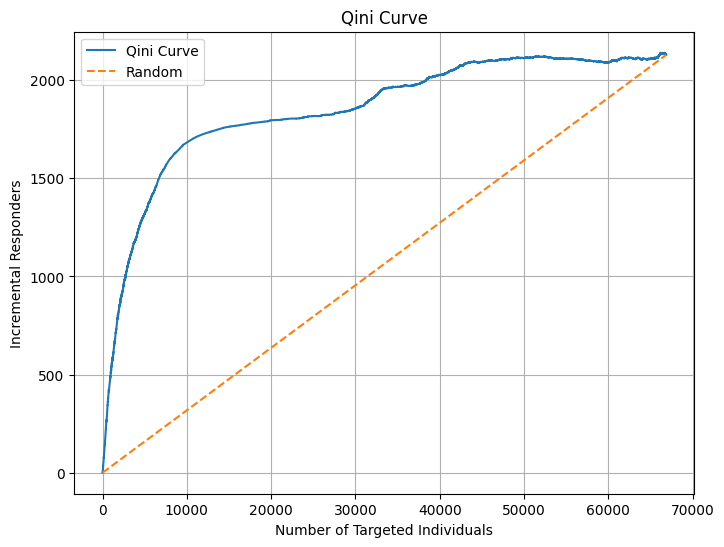

In [18]:
uplift_scores = best_model.predict(X_test)
x_qini, y_qini = qini_curve(y_true=y_test, uplift=uplift_scores, treatment=treat_test)


plt.figure(figsize=(8, 6))
plt.plot(x_qini, y_qini, label='Qini Curve')
plt.plot([0, x_qini[-1]], [0, y_qini[-1]], '--', label='Random')  
plt.xlabel('Number of Targeted Individuals')
plt.ylabel('Incremental Responders')
plt.title('Qini Curve')
plt.legend()
plt.grid(True)
plt.show()


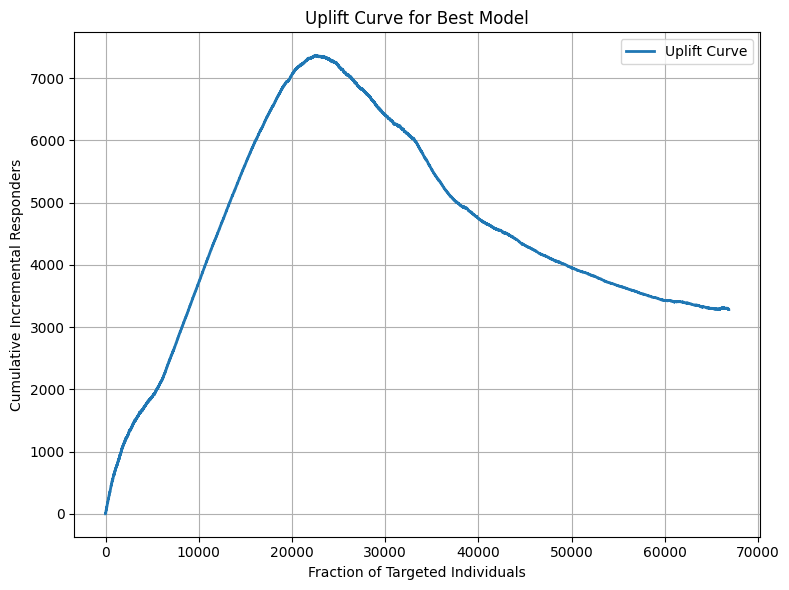

In [ ]:

uplift_scores = best_model.predict(X_test)

x_uplift, y_uplift = uplift_curve(y_true=y_test, uplift=uplift_scores, treatment=treat_test)

plt.figure(figsize=(8, 6))
plt.plot(x_uplift, y_uplift, label=f'Uplift Curve', linewidth=2)
plt.xlabel('Fraction of Targeted Individuals')
plt.ylabel('Cumulative Incremental Responders')
plt.title(f'Uplift Curve for Best Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Targets Dataset

In [21]:
enriched_final_rfm_df.loc[X_test.index, 'Uplift_Score'] = best_model.predict(X_test)


In [22]:
churned_customers = enriched_final_rfm_df[enriched_final_rfm_df['Churn_Label_OCSVM'] == 1]

top_churned_customers = churned_customers.sort_values('Uplift_Score', ascending=False).head(10000)


In [23]:
def assign_discount(uplift):
    if uplift > 0.5:        
        return 0.25
    elif uplift > 0.3:      
        return 0.15
    elif uplift > 0.15:     
        return 0.05
    else:
        return 0.00          


In [24]:
top_churned_customers['Assigned_Discount'] = top_churned_customers['Uplift_Score'].apply(assign_discount)
top_churned_customers['Expected_Revenue_Saved'] = top_churned_customers['Monetary'] * top_churned_customers['Uplift_Score']
top_churned_customers['Discount_Cost'] = top_churned_customers['Monetary'] * top_churned_customers['Assigned_Discount']
top_churned_customers['ROI'] = top_churned_customers['Expected_Revenue_Saved'] / top_churned_customers['Discount_Cost'].replace(0, 1)


In [25]:
top_targets = top_churned_customers.sort_values(by='ROI', ascending=False).head(10000)


In [26]:
top_targets

,CUSTOMER_ID,Recency,Frequency,Monetary,Total_Units,Total_Organic_Discount,Total_Extra_Discount,Total_Discounts,AVG_ORGANIC_DISCOUNT_PER_ORDER,USED_ORGANIC_DISCOUNT_RATIO,...,Churn_Label_IsoForest,LOF_Score,Churn_Label_LOF,Churn_Label_OCSVM,Treatment,Uplift_Score,Assigned_Discount,Expected_Revenue_Saved,Discount_Cost,ROI
150468,ac2517580c4a3e21fa58586f860e6370430375701cccd9...,185,514,74182.6638,805,16451.4200,64.9462,16516.3662,32.006654,1.000000,...,1,-1,1,1,True,0.045880,0.0,3403.516612,0.0,3403.516612
572,00af3bb015852a2310254f962808888de8baf5703dac9c...,1,222,32489.2535,324,5774.8300,68.7165,5843.5465,26.012748,0.990991,...,1,1,0,1,True,0.038482,0.0,1250.238079,0.0,1250.238079
220515,fcb4affb9ca6f43c6cbfd304eacc628b1e0bec420b4430...,794,32,5543.3500,226,0.0000,798.1500,798.1500,0.000000,0.000000,...,1,-1,1,1,True,0.124613,0.0,690.774286,0.0,690.774286
116836,85b7d3bdb4c4a6275bc4b650559f5db6b639d01dafb938...,139,86,5242.9303,391,509.0700,884.6400,1393.7100,5.919419,0.441860,...,1,1,0,1,True,0.091625,0.0,480.385571,0.0,480.385571
82571,5ebef69001bc829e3e20663c0e246f9dd45c48bc5c6b19...,64,92,10484.4612,235,2572.8299,40.1989,2613.0288,27.965542,0.956522,...,1,1,0,1,True,0.040437,0.0,423.960772,0.0,423.960772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188848,d7f9a82423984e75e664167491af16c26ecd221a44a4ea...,229,3,352.2000,3,132.0000,0.0000,132.0000,44.000000,1.000000,...,0,1,0,1,False,NaN,0.0,NaN,0.0,NaN
188887,d806c0e92d7d7985628855d4548f1c04c3395966474376...,547,61,2796.0100,91,46.0000,646.3900,692.3900,0.754098,0.049180,...,0,1,0,1,True,NaN,0.0,NaN,0.0,NaN
188954,d81a959edfb697abd10df381f8bf34e3a45ef131ad16ef...,11,96,13262.6900,182,2000.9500,0.3000,2001.2500,20.843229,1.000000,...,0,1,0,1,False,NaN,0.0,NaN,0.0,NaN
188973,d81f5d45c27704b06d87026d147abe319d3cd65159f76f...,18,124,8829.2312,219,1134.7200,856.6188,1991.3388,9.150968,0.750000,...,1,1,0,1,True,NaN,0.0,NaN,0.0,NaN
